<h1><center><b>KIODNet: Adaptive Multivariate Time Series Classification Framework using Essembled Learning Approach for Indoor Outdoor Detection</center></h1></b>

<h2><b>  Author:</h2></b>

        Bilal Dastagir - ISI LAB, School of Computing, KAIST, Daejeon, South Korea

## Mount Google Colab

In [36]:
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dataset_Path = '/content/gdrive/MyDrive/Datasets/'
    model_Path = '/content/gdrive/MyDrive/models/'
except:
    dataset_Path = '/home/bilz/air/Datasets/'
    model_Path = '/home/bilz/air/models/'
    

dataset_Path_Full = dataset_Path + 'trainingTestingData.csv'
DATA_PATH = dataset_Path_Full
print(DATA_PATH)

/home/bilz/air/Datasets/trainingTestingData.csv


## Parameter Settings 

In [37]:
version = 1
window_size = 6
epoch_number = 100
batch_number = 64
fold_number = 6
input_features = 8
outputs_class = 2

<h2><b>  Importing all the necessary libraries </h2></b>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import scipy.stats as stats
import time
import seaborn as sns
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_curve, auc

## Adaptive Feature Scaling

In [39]:
# Define a class for adaptive feature scaling
class AdaptiveFeatureScaler:
    def __init__(self):
        self.feature_ranges = None

    def fit(self, X):
        # Calculate the range (max - min) for each feature
        self.feature_ranges = X.max(axis=0) - X.min(axis=0)

    def transform(self, X):
        # Scale each feature based on the calculated range
        if self.feature_ranges is None:
            raise ValueError("Scaler not fitted. Call fit() first.")
        return X / self.feature_ranges

    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

## Pre-Functions 

In [40]:
# Function to preprocess data
def preprocessData(dataPath):
    df = pd.read_csv(DATA_PATH)

    columns = ['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime', 'New_Recording', 'IO']
    data = pd.DataFrame(data=df, columns=columns)

    # Convert the string formatted data into float
    data = data.astype('float')

    # AdaptiveFeatureScaler  
    afs = AdaptiveFeatureScaler()
    data_scaled = afs.fit_transform(data[['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime']])

    # Combine the scaled features and the label
    data_scaled['IO'] = data['IO']

    # Continue with the rest of the data processing as before
    states = data_scaled['IO'].value_counts().index
    data_scaled.reset_index(drop=True, inplace=True)
    data_scaled.index = data_scaled.index + 1
    data_scaled.index.name = 'index'

    return df, data_scaled

# Function to balance data by selecting the same number of samples for each class
def balanceData(df, data):
    # Get the value counts of the 'IO' column
    value_counts = df['IO'].value_counts()

    # Find the minimum count of both labels
    min_count = min(value_counts)

    # Filter the DataFrame for 'Outdoor' and 'Indoor' categories
    Outdoor = df[df['IO'] == 0].head(min_count).copy()
    Indoor = df[df['IO'] == 1].head(min_count).copy()

    balanced_data = pd.concat([Outdoor, Indoor], ignore_index=True)

    return balanced_data

# Function to encode the data labels using LabelEncoder
def encodedData(balanced_data):
    # Encoding the Data with suitable labels
    label = LabelEncoder()
    balanced_data['label'] = label.fit_transform(balanced_data['IO'])
    return balanced_data

# Function to standardize the features
def standardizeData(encoded_data):
    X = encoded_data[['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime']]
    y = encoded_data['label']

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    scaled_X = pd.DataFrame(data=X, columns=['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime'])
    scaled_X['label'] = y.values

    return scaled_X, X, y

# Function to adaptiveScaleData the features with AdaptiveFeatureScaler
def adaptiveScaleData(encoded_data):
    X = encoded_data[['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime']]
    y = encoded_data['label']

    afs = AdaptiveFeatureScaler()  # Create an instance of AdaptiveFeatureScaler
    X = afs.fit_transform(X)  # Use fit_transform to transform the features

    scaled_X = pd.DataFrame(data=X, columns=['RSRP', 'RSRQ', 'Light', 'Mag', 'Acc', 'Sound', 'Proximity', 'Daytime'])
    scaled_X['label'] = y.values

    return scaled_X, X, y

# Function to create overlapping frames from the data
def get_frames(df, frame_size, hop_size, n_features=8):
    N_FEATURES = n_features

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        # Get each feature for the current frame
        features = [df[feature].values[i: i + frame_size] for feature in df.columns[:-1]]

        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append(features)
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

# Function to create overlapping frames from the standardized data
def framedData(scaled_X, X, y, window_size=6, features_number=8):
    frame_size = window_size
    hop_size = int(frame_size / 2)
    n_features = features_number

    # Remove rows with NaN values and reset index
    scaled_X = scaled_X.dropna().reset_index(drop=True)
    X, y = get_frames(scaled_X, frame_size, hop_size, n_features)
    return scaled_X, X, y

# Function to split the data with cross-validation
def splitDataWithCrossValidation(X, y, fold_number=6):
    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

    # Creating the K-fold cross-validation iterator
    kfold = StratifiedKFold(n_splits=fold_number, shuffle=True, random_state=0)

    return X_train, X_test, y_train, y_test, kfold

# Define the CNN-LSTM model with 2 parallel 1D CNN branches
def parallel_CNN_LSTM(input_shape, n_outputs):
    inputs = Input(shape=input_shape)

    # First 1D CNN branch
    x1 = Conv1D(64, kernel_size=3, activation='relu')(inputs)
    x1 = MaxPooling1D(2)(x1)
    x1 = LSTM(64)(x1)

    # Second 1D CNN branch
    x2 = Conv1D(64, kernel_size=5, activation='relu')(inputs)
    x2 = MaxPooling1D(2)(x2)
    x2 = LSTM(64)(x2)

    # Concatenate the outputs from both branches
    x = concatenate([x1, x2])

    x = Dropout(0.2)(x)
    outputs = Dense(n_outputs, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Function to train the model using K-fold cross-validation
def trainingModel(model_path, X, y, fold_number=6, epoch_number=100, batch_number=64):
    # Create KFold instance
    kfold = KFold(n_splits=fold_number, shuffle=True)

    # Create empty lists to store the fold models and evaluation results
    fold_models = []
    fold_test_acc = []
    fold_test_f1 = []
    fold_prediction_times = []
    fold_training_times = []

    # Looping over the folds
    for fold, (train_index, val_index) in enumerate(kfold.split(X, y)):
        print(f"Fold {fold+1}:")

        # Get the train and validation sets for this fold
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Define the filepath for the saved model specific to this fold
        filepath = model_path + f"bd_KIODNet_V{version}_W_{window_size}_F_{fold+1}.h5"

        # Define early stopping based on validation loss
        early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

        # Define a checkpoint to monitor the validation accuracy and save the best model
        checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

        input_shape = X_train[0].shape
        # Create the CNN-LSTM model with parallel 1D CNNs
        model = parallel_CNN_LSTM(input_shape, outputs_class)

        # Compile the model
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Start the training time measurement
        start_time = time.time()

        # Train the model with the checkpoint callback for this fold
        history = model.fit(X_train_fold, y_train_fold, epochs=epoch_number, batch_size=batch_number,
                            validation_data=(X_val_fold, y_val_fold), callbacks=[checkpoint, early_stop], verbose=1)

        # End the training time measurement
        end_time = time.time()
        training_time = end_time - start_time

        # Save the fold model to the list
        fold_models.append(model)

        # Evaluate the model on the test set
        test_pred = model.predict(X_test)
        test_pred_labels = np.argmax(test_pred, axis=1)

        if len(y_test.shape) > 1 and y_test.shape[1] > 1:
            test_true_labels = np.argmax(y_test, axis=1)
        else:
            test_true_labels = y_test

        test_acc = accuracy_score(test_true_labels, test_pred_labels)
        test_f1 = f1_score(test_true_labels, test_pred_labels, average='weighted')

        # Calculate the prediction time
        start_time = time.time()
        model.predict(X_test[:1])
        end_time = time.time()
        prediction_time = (end_time - start_time) * 1000  # Convert to milliseconds

        # Save the evaluation results and times to the lists
        fold_test_acc.append(test_acc)
        fold_test_f1.append(test_f1)
        fold_prediction_times.append(prediction_time)
        fold_training_times.append(training_time)

    # Calculate mean and median times for prediction and training
    mean_prediction_time = np.mean(fold_prediction_times) / 1000  # Convert back to seconds
    median_prediction_time = np.median(fold_prediction_times) / 1000  # Convert back to seconds
    mean_training_time = np.mean(fold_training_times)
    median_training_time = np.median(fold_training_times)

    # Calculate the total number of parameters
    total_params = model.count_params()

    # Convert the total number of parameters to kilobytes (KB)
    total_params_kb = total_params / 1024  # 1 KB = 1024 bytes

    # Convert the total number of parameters to megabytes (MB)
    total_memory_mb = total_params * 4 / (1024 * 1024)  # Assuming float32 precision (4 bytes per parameter)

    # Save the averaged model
    averaged_model = fold_models[0]
    averaged_weights = averaged_model.get_weights()

    n_splits = fold_number
    # Loop over the layers of the models and average the weights
    for layer in range(len(averaged_weights)):
        for fold in range(1, n_splits):
            averaged_weights[layer] += fold_models[fold].get_weights()[layer]

        averaged_weights[layer] /= n_splits

    # Set the averaged weights to the averaged model
    averaged_model.set_weights(averaged_weights)
    averaged_filepath = model_path + f"bd_KIODNet_V{version}_W_{window_size}.h5"
    averaged_model.save(averaged_filepath)

    return averaged_model, fold_test_acc, fold_test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb

# Function to draw the confusion matrix and ROC curve
def drawConfusionMatrix(myModel, X_test, y_test):
    class_labels = ['Outdoor', 'Indoor']
    # Measure the time it takes to predict a single sample
    start_time = time.time()
    predict_x = myModel.predict(X_test)
    end_time = time.time()

    # Calculate the prediction time
    prediction_time = end_time - start_time
    print('Prediction time:', prediction_time, 'seconds')

    y_pred = np.argmax(predict_x, axis=1)
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat, xticklabels=class_labels, yticklabels=class_labels, annot=True, linewidths=0.1, fmt='d', cmap='YlGnBu')
    plt.title("Confusion matrix", fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Calculate ROC curve and AUC
    y_prob = predict_x[:, 1]  # Probability for the positive class (Indoor)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

## Data Preprocessing

In [41]:
# Preprocess data
df, data = preprocessData(DATA_PATH)

## Data Balancing

In [42]:
# Balance the data
balanced_data = balanceData(df, data)

## Data Encoding

In [43]:
# Encode the data
encoded_data = encodedData(balanced_data)

## Data Standardizing

In [44]:
# Standardize the data
scaled_X, X, y = standardizeData(encoded_data)


## Data Framing

In [45]:
# Get framed data
scaled_X, X, y = framedData(scaled_X, X, y)

/tmp/ipykernel_1484035/1306814225.py:86: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


## Cross-Validation Datasets Generation

In [46]:
# Split the data with cross-validation
X_train, X_test, y_train, y_test, kfold = splitDataWithCrossValidation(X, y, fold_number)

## Essemble Learning 

In [47]:
# Train the model and get the required outputs
trained_model, test_acc, test_f1, mean_prediction_time, median_prediction_time, mean_training_time, median_training_time, total_memory_mb, total_params_kb = trainingModel(model_Path, X_train, y_train)


Fold 1:
Epoch 1/100
3488/3497 [============================>.] - ETA: 0s - loss: 0.0200 - accuracy: 0.9936
Epoch 1: val_accuracy improved from -inf to 0.99629, saving model to /home/bilz/air/models/bd_KIODNet_V1_W_6_F_1.h5
3497/3497 [==============================] - 12s 3ms/step - loss: 0.0199 - accuracy: 0.9936 - val_loss: 0.0100 - val_accuracy: 0.9963
Epoch 2/100
3481/3497 [============================>.] - ETA: 0s - loss: 0.0102 - accuracy: 0.9965
Epoch 2: val_accuracy improved from 0.99629 to 0.99658, saving model to /home/bilz/air/models/bd_KIODNet_V1_W_6_F_1.h5
3497/3497 [==============================] - 9s 3ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0095 - val_accuracy: 0.9966
Epoch 3/100
3496/3497 [============================>.] - ETA: 0s - loss: 0.0083 - accuracy: 0.9971
Epoch 3: val_accuracy did not improve from 0.99658
3497/3497 [==============================] - 10s 3ms/step - loss: 0.0083 - accuracy: 0.9971 - val_loss: 0.0100 - val_accuracy: 0.9963
Epoch 4/

## Display Results

In [48]:
print(f"Accuracy: {test_acc}")
print(f"F1-score: {test_f1}")
print(f"Mean Prediction Time (sec): {mean_prediction_time:.6f}")
print(f"Median Prediction Time (sec): {median_prediction_time:.6f}")
print(f"Mean Training Time (sec): {mean_training_time:.6f}")
print(f"Median Training Time (sec): {median_training_time:.6f}")
print(f"Mean Single Prediction Time (msec): {mean_prediction_time * 1000:.3f}")
print(f"Median Single Prediction Time (msec): {median_prediction_time * 1000:.3f}")
print(f"Mean Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Median Required Memory (Mb): {total_memory_mb:.4f}")
print(f"Mean Model Parameters (K): {total_params_kb:.2f}")
print(f"Median Model Parameters (K): {total_params_kb:.2f}")

Accuracy: [0.9971403464351142, 0.9969765121162926, 0.9968871479423899, 0.9969616180873088, 0.9969020419713737, 0.9966190554206819]
F1-score: [0.997140346218162, 0.9969765120961714, 0.99688714549791, 0.9969616177462594, 0.9969020416827385, 0.9966190523966709]
Mean Prediction Time (sec): 0.027798
Median Prediction Time (sec): 0.026995
Mean Training Time (sec): 156.302400
Median Training Time (sec): 148.115200
Mean Single Prediction Time (msec): 27.798
Median Single Prediction Time (msec): 26.995
Mean Required Memory (Mb): 0.2691
Median Required Memory (Mb): 0.2691
Mean Model Parameters (K): 68.88
Median Model Parameters (K): 68.88


## Confusion Matrix

2099/2099 [==============================] - 2s 961us/step
Prediction time: 2.3386166095733643 seconds


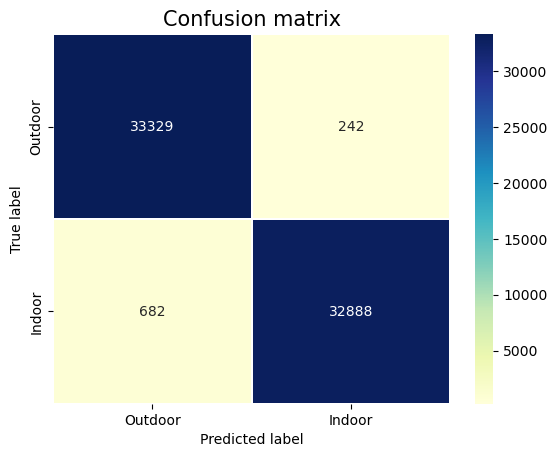

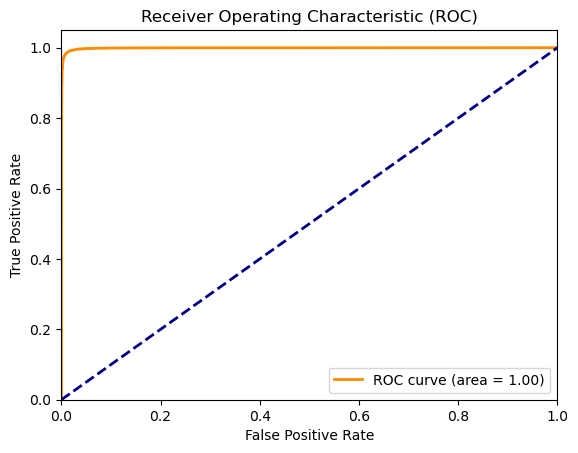

In [49]:
# Display confusion matrix and ROC curve
drawConfusionMatrix(trained_model, X_test, y_test)